# **Misclassification spotter**


Example application of spectrogram approach to identify misclassified audios in a dataset

## Libraries

In [63]:
import os
import pandas as pd
import librosa.display
import numpy as np
from pandas.core.common import flatten
import datetime
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import scipy
import pickle
from pathlib import Path

In [64]:
wd = os.getcwd()

DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures")

## Load dataset

In [65]:
dftype = "reduced"
spec_df = pd.read_pickle(os.path.join(os.path.sep, DATA, "df_focal_"+dftype+".pkl"))

labels = spec_df.call_lable.values
calltypes = sorted(list(set(labels)))

embedding_filename = 'basic_UMAP_'+dftype+'_default_params.csv'
embedding = np.loadtxt(os.path.join(os.path.sep, DATA, embedding_filename),delimiter=";")

# Spotter

## Find nearest neighbors

In [66]:
k=5

nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)

# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:,1:]  
distances = distances[:,1:]

In [67]:
label_col = 'call_lable'
labels = spec_df[label_col].tolist()

In [68]:
wrong_neighbors = []
wrong_neighbors_row_num = []
wrong_datapoint = []
wrong_rownum = []

for i in range(spec_df.shape[0]):
    datapoint_label = labels[i]
    neighbors = indices[i]
    neighbor_labels = [labels[x] for x in neighbors]
    
    if datapoint_label not in neighbor_labels:
        wrong_neighbors.append(neighbor_labels)
        wrong_neighbors_row_num.append(neighbors)
        wrong_datapoint.append(datapoint_label)
        wrong_rownum.append(i)

In [69]:
len(wrong_neighbors)

575

In [70]:
wrong_df = pd.DataFrame(list(zip(wrong_rownum, wrong_datapoint)), 
               columns =['row_num', 'call_lable']) 

wrong_neighbors_arr = np.vstack(wrong_neighbors)

for i in range(wrong_neighbors_arr.shape[1]):
    col_name = "neighbor_"+str(i+1)
    wrong_df[col_name] = wrong_neighbors_arr[:,i]

wrong_neighbors_row_num_arr = np.vstack(wrong_neighbors_row_num)

for i in range(wrong_neighbors_row_num_arr.shape[1]):
    col_name = "neighbor_"+str(i+1)+"_rownum"
    wrong_df[col_name] = wrong_neighbors_row_num_arr[:,i]

wrong_df

,row_num,call_lable,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_1_rownum,neighbor_2_rownum,neighbor_3_rownum,neighbor_4_rownum,neighbor_5_rownum
0,8,agg,soc,soc,soc,cc,soc,371,2384,2385,5120,1663
1,9,agg,cc,soc,cc,soc,cc,5644,2342,6180,2169,6260
2,11,agg,mo,cc,soc,mo,ld,3504,5741,3867,4820,1027
3,14,agg,cc,mo,cc,soc,cc,5038,600,6002,2628,5613
4,16,al,sn,sn,sn,sn,sn,1040,200,384,998,1006
...,...,...,...,...,...,...,...,...,...,...,...,...
570,6368,cc,soc,soc,soc,ld,soc,1326,523,788,621,2039
571,6388,cc,soc,agg,mo,soc,soc,4268,554,4819,1929,1650
572,6390,cc,sn,sn,sn,sn,sn,1041,465,1021,1045,468
573,6393,cc,ld,soc,mo,mo,soc,805,729,2673,721,2697


### Descriptive statistics

In [71]:
wrong_df['call_lable'].value_counts()

soc    138
al      98
agg     83
mo      75
cc      65
ld      64
sn      52
Name: call_lable, dtype: int64

In [72]:
w = pd.DataFrame(wrong_df['call_lable'].value_counts())
w.sort_index(inplace=True)

a = pd.DataFrame(spec_df[label_col].value_counts())
a.sort_index(inplace=True)

In [73]:
tab = pd.DataFrame({'mispositioned': w['call_lable'], 'overall': a[label_col], 'percentage': 100*(w['call_lable']/a[label_col])})
tab

,mispositioned,overall,percentage
agg,83,375,22.133333
al,98,646,15.170279
cc,65,1477,4.400812
ld,64,164,39.024390
mo,75,759,9.881423
sn,52,1855,2.803235
soc,138,1154,11.958406


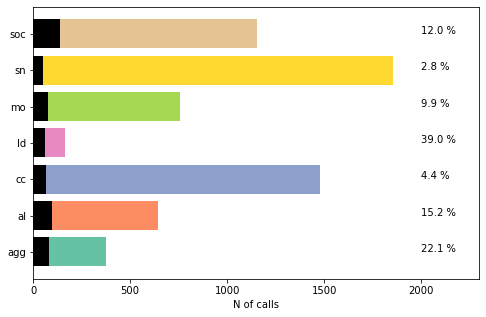

In [74]:
fig = plt.figure(figsize=(8,5))
labelcounts = pd.DataFrame(spec_df[label_col].value_counts())
labelcounts.sort_index(inplace=True)
pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
plt.barh(labelcounts.index, labelcounts[label_col].values, color = pal)
plt.barh(labelcounts.index, tab.mispositioned.values, color = 'black')
plt.xlabel("N of calls")
plt.xlim(0,2300)
for index, value in enumerate(tab.mispositioned.values):
    plt.text(2000, index, str(round(tab.loc[tab.index[index],'percentage'],1))+" %")

### Clear cases

Identify "clear" cases, where all neighbors are of the same label type.

In [75]:
nb_cols=[]
for i in range(k):
    nb_cols.append('neighbor_'+str(i+1))
nb_cols

['neighbor_1', 'neighbor_2', 'neighbor_3', 'neighbor_4', 'neighbor_5']

In [76]:
clear_cases = []

for i in range(wrong_df.shape[0]):
    nbs = wrong_df.loc[i,nb_cols].tolist()
    if len(set(nbs))==1:
        clear_cases.append('yes')
    else:
        clear_cases.append('no')

In [77]:
wrong_df['clear_case'] = clear_cases
wrong_df.clear_case.value_counts()

no     348
yes    227
Name: clear_case, dtype: int64

Okay, for some calls, there seems to be a clear mislabeling. Plot some example calls:

In [78]:
wrong_df.head()

,row_num,call_lable,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_1_rownum,neighbor_2_rownum,neighbor_3_rownum,neighbor_4_rownum,neighbor_5_rownum,clear_case
0,8,agg,soc,soc,soc,cc,soc,371,2384,2385,5120,1663,no
1,9,agg,cc,soc,cc,soc,cc,5644,2342,6180,2169,6260,no
2,11,agg,mo,cc,soc,mo,ld,3504,5741,3867,4820,1027,no
3,14,agg,cc,mo,cc,soc,cc,5038,600,6002,2628,5613,no
4,16,al,sn,sn,sn,sn,sn,1040,200,384,998,1006,yes


Remove unknown calls and only select clear cases

In [79]:
wrong_subset = wrong_df.loc[wrong_df['clear_case']=='yes']
wrong_subset = wrong_subset.loc[wrong_subset['call_lable']!='unk']

# Need to reset index, else won't be able to accces ith row of original dataframe
spec_df.reset_index(inplace=True)

calltypes = sorted(list(set(wrong_subset['call_lable'])))
calltypes

['agg', 'al', 'cc', 'ld', 'mo', 'sn', 'soc']

In [80]:
wrong_subset.head()

,row_num,call_lable,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_1_rownum,neighbor_2_rownum,neighbor_3_rownum,neighbor_4_rownum,neighbor_5_rownum,clear_case
4,16,al,sn,sn,sn,sn,sn,1040,200,384,998,1006,yes
6,18,al,sn,sn,sn,sn,sn,1576,10,1052,3490,3459,yes
12,40,al,cc,cc,cc,cc,cc,5191,5281,5600,5935,5672,yes
14,42,al,cc,cc,cc,cc,cc,5213,5071,6183,5534,6334,yes
20,58,al,sn,sn,sn,sn,sn,1025,757,1046,1023,3535,yes


In [81]:
w = pd.DataFrame(wrong_subset['call_lable'].value_counts())
w.sort_index(inplace=True)

a = pd.DataFrame(spec_df[label_col].value_counts())
a.sort_index(inplace=True)

In [82]:
tab = pd.DataFrame({'mispositioned': w['call_lable'], 'overall': a[label_col], 'percentage': 100*(w['call_lable']/a[label_col])})
tab

,mispositioned,overall,percentage
agg,25,375,6.666667
al,37,646,5.727554
cc,11,1477,0.744753
ld,31,164,18.902439
mo,35,759,4.611331
sn,14,1855,0.754717
soc,74,1154,6.412478


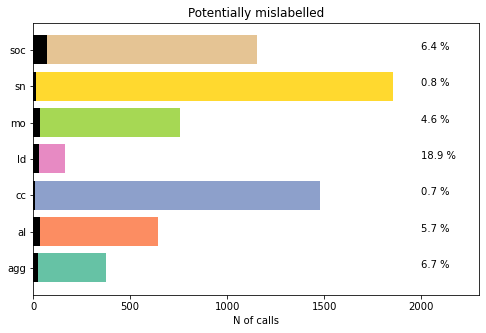

In [83]:
fig = plt.figure(figsize=(8,5))
labelcounts = pd.DataFrame(spec_df[label_col].value_counts())
labelcounts.sort_index(inplace=True)
pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
plt.barh(labelcounts.index, labelcounts[label_col].values, color = pal)
plt.barh(labelcounts.index, tab.mispositioned.values, color = 'black')
plt.xlabel("N of calls")
plt.title("Potentially mislabelled")
plt.xlim(0,2300)
for index, value in enumerate(tab.mispositioned.values):
    plt.text(2000, index, str(round(tab.loc[tab.index[index],'percentage'],1))+" %")

### Plot example misclassified calls

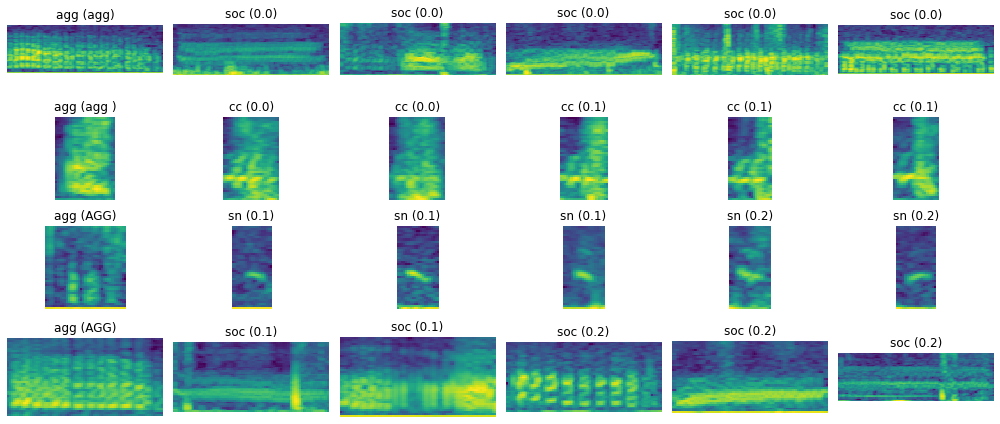

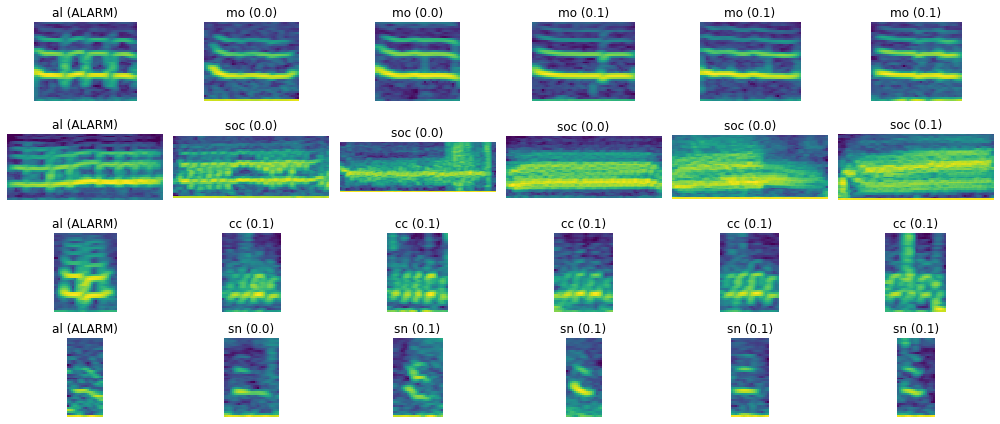

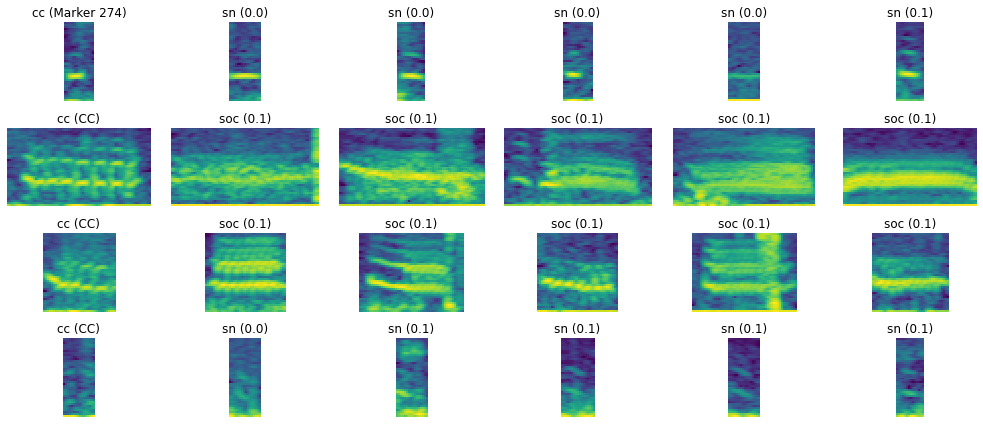

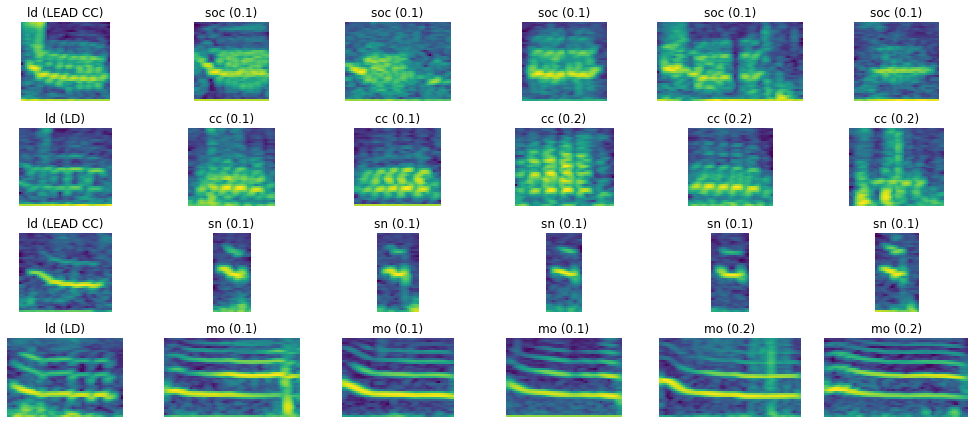

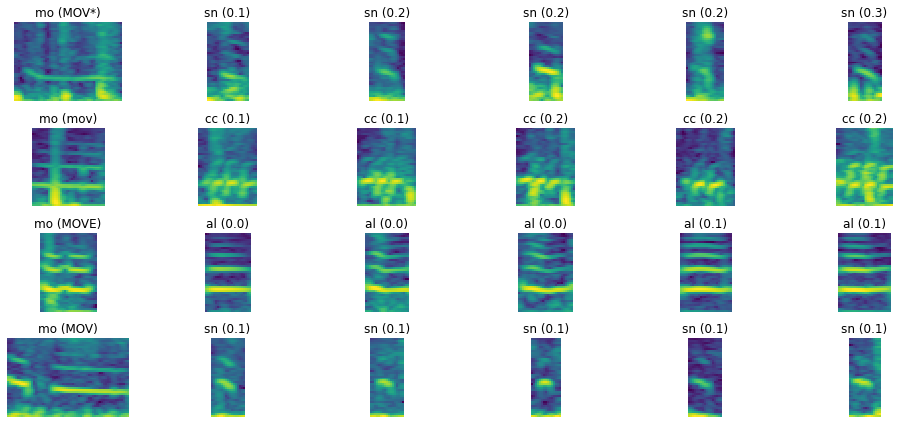

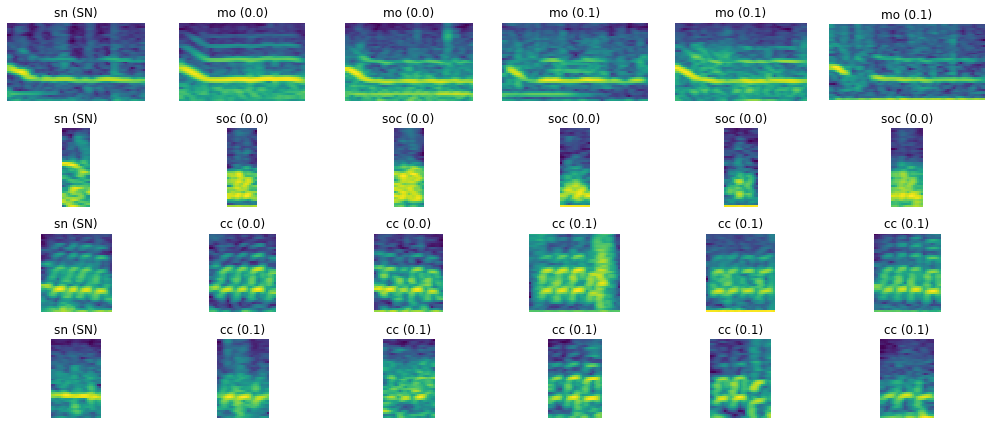

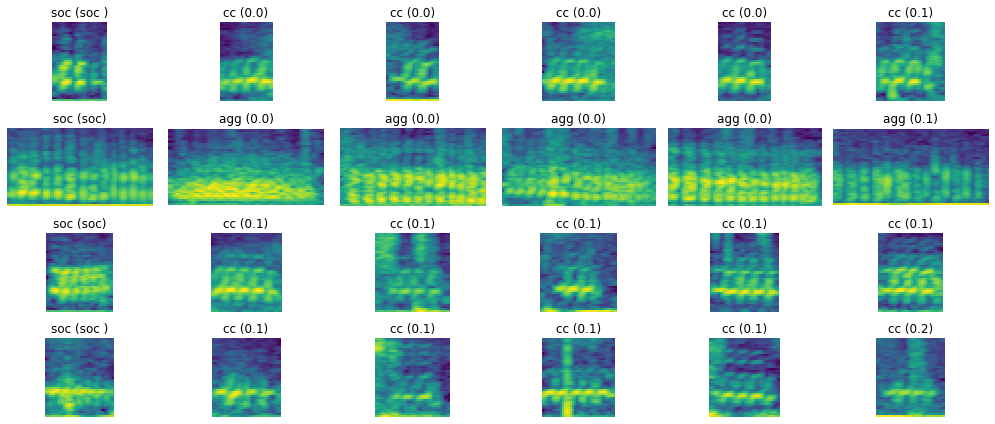

In [84]:
data=embedding
for calltype in calltypes:
    fig = plt.figure(figsize=(14,6))
    fig_name = 'NN_misclass_Viz_'+calltype
    p=1

    subset_df = wrong_subset.loc[wrong_subset['call_lable']==calltype,:]

      # randomly choose 4
    examples = subset_df.sample(n=4, random_state=1234)
    examples.reset_index(inplace=True)
  
    for i in range(examples.shape[0]):
        ori_rownum = examples.loc[i,'row_num']
        spec = spec_df.loc[ori_rownum,'spectrograms']
        plt.subplot(4, 6, p)
        plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
        plt.axis('off')
        original_name = spec_df.loc[ori_rownum,'Name']
        plt.title(calltype+" ("+original_name+")")
        p=p+1

        for neighbor in range(1,6):
            neighbor_label = examples.loc[i,'neighbor_'+str(neighbor)]
            nb_rownum = examples.loc[i,'neighbor_'+str(neighbor)+'_rownum']
            neighbor_spec = spec_df.loc[nb_rownum,'spectrograms']
            dist = scipy.spatial.distance.euclidean(data[ori_rownum,:], data[nb_rownum,:])
            plt.subplot(4, 6, p)
            plt.imshow(neighbor_spec, interpolation='nearest', origin='lower', aspect='equal') 
            plt.axis('off')
            plt.title(examples.loc[i,'neighbor_'+str(neighbor)]+" ("+str(round(dist,1))+")")
            p=p+1
        
    plt.tight_layout() 
    plt.savefig(os.path.join(os.path.sep,FIGURES,fig_name), facecolor="white")

### Random select calls for manual assignment

From the subset of clearly misclassified calls, select a reasonable amount that Vlad and Baptiste can go through manually and check.

In [85]:
random_subset = wrong_subset.sample(n=100, random_state=1)
random_subset

,row_num,call_lable,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_1_rownum,neighbor_2_rownum,neighbor_3_rownum,neighbor_4_rownum,neighbor_5_rownum,clear_case
118,807,ld,soc,soc,soc,soc,soc,1379,163,771,795,699,yes
401,4128,mo,al,al,al,al,al,355,2487,989,2577,4371,yes
235,1810,soc,cc,cc,cc,cc,cc,5947,5312,6381,5169,5666,yes
161,1173,sn,al,al,al,al,al,2878,2799,2890,4527,3782,yes
468,4730,mo,soc,soc,soc,soc,soc,2523,1309,4477,2524,4025,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,1990,al,mo,mo,mo,mo,mo,4596,4665,4754,4837,4625,yes
140,958,soc,cc,cc,cc,cc,cc,6168,5127,5608,6086,6308,yes
300,2341,soc,cc,cc,cc,cc,cc,5217,5519,5448,5005,5404,yes
248,1879,mo,cc,cc,cc,cc,cc,5331,6312,4990,5413,6341,yes


In [86]:
random_subset['callID'] = [spec_df.loc[x,'callID'] for x in random_subset.row_num]
random_subset['spectrograms'] = [spec_df.loc[x,'spectrograms'] for x in random_subset.row_num]
random_subset['raw_audio'] = [spec_df.loc[x,'raw_audio'] for x in random_subset.row_num]
random_subset['samplerate_hz'] = [spec_df.loc[x,'samplerate_hz'] for x in random_subset.row_num]
random_subset['Name'] = [spec_df.loc[x,'Name'] for x in random_subset.row_num]
random_subset['nb_audio'] = [spec_df.loc[x,'raw_audio'] for x in random_subset.neighbor_1_rownum]
random_subset['nb_samplerate_hz'] = [spec_df.loc[x,'samplerate_hz'] for x in random_subset.neighbor_1_rownum]

In [87]:
for nb_num in range(1,6):
    random_subset['nb_'+str(nb_num)+'_audio'] = [spec_df.loc[x,'raw_audio'] for x in random_subset['neighbor_'+str(nb_num)+'_rownum']]
    random_subset['nb_'+str(nb_num)+'_samplerate_hz'] = [spec_df.loc[x,'samplerate_hz'] for x in random_subset['neighbor_'+str(nb_num)+'_rownum']]
    random_subset['nb_'+str(nb_num)+'_spectrograms'] = [spec_df.loc[x,'spectrograms'] for x in random_subset['neighbor_'+str(nb_num)+'_rownum']]

In [88]:
random_subset.reset_index(inplace=True)

#### Save calls

In [89]:
outname = os.path.join(os.path.sep, DATA, 'random_sub_missclassi')
print(outname)
random_subset.to_pickle(outname+'.pkl')

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/processed/random_sub_missclassi


In [90]:
#random_subset.samplerate_hz.value_counts()

### Save random subset wavs

In [91]:
random_subset = pd.read_pickle(os.path.join(os.path.sep, DATA, 'random_sub_missclassi')+'.pkl')

In [95]:
random_subset

,index,row_num,call_lable,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_1_rownum,neighbor_2_rownum,...,nb_2_spectrograms,nb_3_audio,nb_3_samplerate_hz,nb_3_spectrograms,nb_4_audio,nb_4_samplerate_hz,nb_4_spectrograms,nb_5_audio,nb_5_samplerate_hz,nb_5_spectrograms
0,118,807,ld,soc,soc,soc,soc,soc,1379,163,...,"[[-4.901206, -6.0010366, -9.109212, -12.539943...","[0.01171875, 0.021484375, 0.01953125, 0.019531...",8000,"[[-0.76804733, -0.9459286, -0.9663677, -0.6889...","[0.01171875, 0.0078125, 0.009765625, 0.0058593...",8000,"[[-5.7869587, -6.2139835, -6.741562, -6.682081...","[-0.01171875, -0.01171875, -0.013671875, -0.01...",8000,"[[-6.388323, -6.125843, -5.5775833, -5.546608,..."
1,401,4128,mo,al,al,al,al,al,355,2487,...,"[[-25.54695, -25.13933, -24.25471, -23.501272,...","[0.00390625, 0.00390625, 0.005859375, 0.005859...",8000,"[[-23.381548, -22.871706, -22.364317, -22.9857...","[-0.01171875, -0.013671875, -0.01171875, -0.01...",8000,"[[-30.975853, -32.15076, -34.219814, -33.40433...","[0.0234375, 0.025390625, 0.025390625, 0.023437...",8000,"[[-20.83456, -21.09601, -21.892141, -22.789398..."
2,235,1810,soc,cc,cc,cc,cc,cc,5947,5312,...,"[[-26.290243, -25.084631, -24.247702, -25.5405...","[0.0, 0.001953125, 0.0078125, 0.0078125, 0.007...",8000,"[[-20.121859, -20.208864, -20.337297, -20.1201...","[-0.0234375, -0.021484375, -0.048828125, -0.05...",8000,"[[-26.932697, -28.048748, -31.372833, -35.9489...","[0.0060765743, 0.0031963587, -0.001137495, -0....",48000,"[[-38.663956, -39.700897, -42.176624, -43.4750..."
3,161,1173,sn,al,al,al,al,al,2878,2799,...,"[[-27.783468, -26.476675, -25.881119, -25.5556...","[0.00390625, 0.001953125, 0.00390625, 0.003906...",8000,"[[-25.42329, -26.164001, -27.551735, -28.11142...","[0.080078125, 0.083984375, 0.080078125, 0.0839...",8000,"[[-8.165855, -8.811497, -10.796959, -14.052523...","[-0.0234375, -0.025390625, -0.025390625, -0.02...",8000,"[[-22.848179, -22.722296, -22.579714, -22.7225..."
4,468,4730,mo,soc,soc,soc,soc,soc,2523,1309,...,"[[-9.126039, -8.945954, -8.795756, -8.969731, ...","[0.00390625, 0.005859375, 0.001953125, 0.00195...",8000,"[[-29.695261, -30.772951, -32.807816, -31.6047...","[0.005859375, 0.0078125, 0.005859375, 0.007812...",8000,"[[-24.912033, -25.400497, -25.861698, -24.9828...","[0.005859375, 0.005859375, -0.001953125, 0.0, ...",8000,"[[-28.546856, -28.747454, -29.597588, -31.2578..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,260,1990,al,mo,mo,mo,mo,mo,4596,4665,...,"[[-40.05514, -37.677475, -35.31554, -34.712425...","[0.0029883385, 0.0030322075, 0.0032827854, 0.0...",48000,"[[-24.856443, -25.415388, -27.02536, -29.34288...","[0.0029808283, 0.00314641, 0.003222704, 0.0032...",48000,"[[-43.71984, -41.07485, -36.817863, -32.559612...","[0.0012094975, 0.00031292439, -0.00011861324, ...",48000,"[[-31.760677, -31.059063, -30.14013, -29.96053..."
96,140,958,soc,cc,cc,cc,cc,cc,6168,5127,...,"[[-19.183758, -18.41818, -18.101376, -19.96773...","[0.0, -0.021484375, -0.01171875, -0.005859375,...",8000,"[[-20.588114, -18.2535, -11.9079275, -8.05273,...","[-0.00390625, -0.009765625, 0.005859375, 0.0, ...",8000,"[[-16.526546, -16.820984, -18.198528, -21.2911...","[0.0, 0.0, 0.0, -0.00390625, -0.001953125, 0.0...",8000,"[[-21.178703, -21.286137, -21.968609, -21.4526..."
97,300,2341,soc,cc,cc,cc,cc,cc,5217,5519,...,"[[-36.797237, -31.10299, -27.791668, -27.47390...","[0.0021636486, 0.0021525621, 0.0021430254, 0.0...",48000,"[[-28.891819, -26.869888, -24.73796, -24.3511,...","[-0.01953125, -0.015625, -0.013671875, -0.0175...",8000,"[[-18.66069, -18.760403, -18.268698, -17.56264...","[0.0234375, 0.01953125, 0.017578125, 0.0214843...",8000,"[[-6.960165, -7.7445793, -9.86755, -12.465868,..."
98,248,1879,mo,cc,cc,cc,cc,cc,5331,6312,...,"[[-25.436024, -20.405518, -14.647969, -11.1169...","[0.064453125, 0.0, -0.0234375, -0.00390625, 0....",8000,"[[-9.221613, -9.157368, -9.785242, -11.766037,...","[-0.0234375, -0.0234375, -0.02

### Wavs

In [93]:
os.path.join(os.path.sep, DATA, 'misclassi_calls')

'/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/processed/misclassi_calls'

In [94]:
MISCLASSI_OUT = os.path.join(os.path.sep, DATA, 'misclassi_calls')

if (not os.path.isdir(MISCLASSI_OUT)):
    os.mkdir(MISCLASSI_OUT)

In [96]:
# Need to resample all at same samplerate!!!!
import soundfile as sf
from scipy.io import wavfile
import scipy.signal as sps


def write_wav(uid, data, sr):
    filename = str(uid)+'.wav'
    #if sr == SR:
    #    sf.write(filename, data, sr, subtype='PCM_16')
    #else: # resample
    #    print("Resampled for "+filename)
    #    number_of_samples = round(len(data) * float(SR) / sr)
    #    data = sps.resample(data, number_of_samples)
    sf.write(filename, data, sr, subtype='PCM_24')

os.chdir(MISCLASSI_OUT)

x=random_subset.apply(lambda row: write_wav(row['callID'], row['raw_audio'], row['samplerate_hz']), axis=1)

os.chdir(wd)

### Spec imgs

In [94]:
MISCLASSI_IMG_OUT = os.path.join(os.path.sep, DATA, 'misclassi_imgs')

if (not os.path.isdir(MISCLASSI_IMG_OUT)):
    os.mkdir(MISCLASSI_IMG_OUT)

In [100]:
n_ticks=3
FFT_WIN = 0.03
FFT_HOP = FFT_WIN/8
HOP_LEN = int(0.03*SR)
FMAX = 4000

for i in range(random_subset.shape[0]):
#for i in range(3):
    plt.figure(figsize=(12, 2))
    outname = str(random_subset.loc[i,'index'])+'.jpg'
    ori_rownum = random_subset.loc[i,'row_num']
    spec = spec_df.loc[ori_rownum,'spectrograms']
    plt.subplot(1, 6, 1)
    librosa.display.specshow(spec,sr=SR, hop_length=HOP_LEN , fmax=FMAX, y_axis='mel', cmap='inferno')

    # Generate axis labels
    #n_frames = spec.shape[1]
    duration = FFT_HOP*spec.shape[1]
    step_size = round(duration/n_ticks,2)
    myticks = np.arange(0,duration, step_size)
    plt.xticks([round(x/FFT_HOP,0) for x in myticks], [str(round(x,2)) for x in myticks])

    plt.title(spec_df.loc[ori_rownum,'call_lable'])
    p=2


    for neighbor in range(1,6):
        neighbor_label = random_subset.loc[i,'neighbor_'+str(neighbor)]
        nb_rownum = random_subset.loc[i,'neighbor_'+str(neighbor)+'_rownum']
        neighbor_spec = spec_df.loc[nb_rownum,'spectrograms']
        plt.subplot(1, 6, p)
        librosa.display.specshow(neighbor_spec,sr=SR, hop_length=HOP_LEN , fmax=FMAX, cmap='inferno')
        plt.xticks([round(x/FFT_HOP,0) for x in myticks], [str(round(x,2)) for x in myticks])
        plt.title(random_subset.loc[i,'neighbor_'+str(neighbor)])
        p=p+1

    plt.savefig(os.path.join(os.path.sep, MISCLASSI_IMG_OUT, outname))
    plt.close()


#### Info file

In [97]:
outname = os.path.join(os.path.sep, DATA, 'info.csv')
random_subset[['callID', 'call_lable', 'neighbor_1']].to_csv(outname, index=False)

In [98]:
x=pd.read_csv(outname)
x

,callID,call_lable,neighbor_1
0,HM_LT_R07_AUDIO_file_6_(2017_08_25-06_44_59)_A...,ld,soc
1,HM_VHMM017_RSTB_R23_20190708-20190720_file_10_...,mo,al
2,HM_VHMF001_HTB_R20_20190707-20190719_file_8_(2...,soc,cc
3,HM_RT_R10_20170903-20170908_file_4_(2017_09_05...,sn,al
4,HM_VLF206_SOUNDFOC_20170806_3___14:34.970,mo,soc
...,...,...,...
95,HM_VHMF010_SOUNDFOC_20190714-028___1:56:23.014,al,mo
96,HM_LT_R09_20170903-20170908_file_4_(2017_09_05...,soc,cc
97,HM_VHMF019_MBTB_R25_20190707-20190719_file_6_(...,soc,cc
98,HM_VHMF001_HTB_R20_20190707-20190719_file_8_(2...,mo,cc


In [99]:
x.to_csv(outname, index=False, sep=";")

In [100]:
outname

'/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/processed/info.csv'